In [1]:
import warnings
warnings.filterwarnings("ignore")

def warn(*args, **kwargs):
    pass

warnings.warn = warn

with warnings.catch_warnings():
   warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
from scipy import stats
from scipy.stats import entropy
from pywt import wavedec
from scipy.signal import welch

In [3]:
from mne_features.feature_extraction import extract_features
# https://mne.tools/mne-features/api.html

In [4]:
import mne
from mne.io import concatenate_raws, read_raw_edf
from mne.decoding import CSP, SPoC
from mne.preprocessing import ICA
from mne.datasets import eegbci

import glob
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, ShuffleSplit, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from lightgbm import LGBMClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from utils import preprocess_data

In [6]:
# Features we can extract from MNE:

features_extract_fn = [
    "mean",
    "variance",
    "std",
    "ptp_amp",
    "skewness",
    "kurtosis",
    "rms",
    "quantile",
    "hurst_exp",
    "app_entropy",
    "samp_entropy",
    "decorr_time",
    "pow_freq_bands",
    "hjorth_mobility_spect",
    "hjorth_complexity_spect",
    "hjorth_mobility",
    "hjorth_complexity",
    "higuchi_fd",
    "katz_fd",
    "zero_crossings",
    "line_length",
    "spect_slope",
    "spect_entropy",
    "svd_entropy",
    "svd_fisher_info",
    "energy_freq_bands",
    "spect_edge_freq",
    "wavelet_coef_energy",
    "teager_kaiser_energy",
    "max_cross_corr",
    "phase_lock_val",
    "nonlin_interdep",
    "time_corr",
    "spect_corr"
]

In [7]:
files = glob.glob('../../files/S001/*.edf')

'''
https://github.com/mne-tools/mne-python/blob/main/mne/datasets/eegbci/eegbci.py#L110
=========  ===================================
run        task
=========  ===================================
1          Baseline, eyes open
2          Baseline, eyes closed
3, 7, 11   Motor execution: left vs right hand
4, 8, 12   Motor imagery: left vs right hand
5, 9, 13   Motor execution: hands vs feet
6, 10, 14  Motor imagery: hands vs feet
=========  ===================================
'''
raws = []
f = [5,9,13]
# ,6,10,14]
for i in f:
    print(i)
    current_file = files[i-1]
    r = read_raw_edf(current_file, preload=True, stim_channel='auto')
    events, _ = mne.events_from_annotations(r)
    if i in [5, 9, 13]:
        new_labels_events = {1:'rest', 2:'action_hand', 3:'action_feet'} # action
    else:
        new_labels_events = {1:'rest', 2:'imagine_hand', 3:'imagine_feet'} # imagine
    new_annot = mne.annotations_from_events(events=events, event_desc=new_labels_events, sfreq=r.info['sfreq'], orig_time=r.info['meas_date'])
    r.set_annotations(new_annot)
    raws.append(r)
    
raw_obj = concatenate_raws(raws)

5
Extracting EDF parameters from /Users/owalid/42/post_intership/total-perspective-vortex/files/S001/S001R11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T0', 'T1', 'T2']
9
Extracting EDF parameters from /Users/owalid/42/post_intership/total-perspective-vortex/files/S001/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T0', 'T1', 'T2']
13
Extracting EDF parameters from /Users/owalid/42/post_intership/total-perspective-vortex/files/S001/S001R02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Used Annotations descriptions: ['T0']


In [8]:
original_raw = raw_obj.copy()

# filters
notch_freq = 60
original_raw.notch_filter(notch_freq, fir_design='firwin')

# low_cutoff = 8
# high_cutoff = 40
# original_raw.filter(low_cutoff, high_cutoff, fir_design='firwin')

events, event_dict = mne.events_from_annotations(original_raw)
print(original_raw.info)
print(event_dict)
picks = mne.pick_types(original_raw.info, meg=True, eeg=True, stim=False, eog=False, exclude='bads')
eegbci.standardize(original_raw)
montage = mne.channels.make_standard_montage('standard_1005')
original_raw.set_montage(montage)

## ICA
n_components = 10
ica = ICA(n_components=n_components, random_state=97, max_iter=800)
ica.fit(original_raw)
components_to_excludes, scores = ica.find_bads_eog(original_raw, ch_name='Fpz')
if components_to_excludes is not None and len(components_to_excludes) > 0:
    ica.exclude = components_to_excludes
    original_raw = ica.apply(original_raw)
else:
    print("No components to exclude")

event_id = {'action_hand': 1, 'action_feet': 2}
events, event_dict = mne.events_from_annotations(original_raw, event_id=event_id)
tmin = -0.5  # Time before event in seconds
tmax = 4.  # Time after event in seconds
epochs = mne.Epochs(original_raw, events, event_dict, tmin, tmax, proj=True, picks=picks, baseline=None, preload=True)

Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1057 samples (6.606 sec)



Used Annotations descriptions: ['action_feet', 'action_hand', 'rest']
<Info | 7 non-empty values
 bads: []
 ch_names: Fc5., Fc3., Fc1., Fcz., Fc2., Fc4., Fc6., C5.., C3.., C1.., ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
>
{'action_feet': 1, 'action_hand': 2, 'rest': 3}
Fitting ICA to data using 64 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Selecting by number: 10 components
Fitting ICA took 0.6s.
Using EOG channel: Fpz
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1600 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transiti

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


In [9]:
y = epochs.events[:, -1] - 1
y.shape

(30,)

## Get features importances

/Users/owalid/.pyenv/versions/3.8.12/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/owalid/.pyenv/versions/3.8.12/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/owalid/.pyenv/versions/3.8.12/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/owalid/.pyenv/versions/3.8.12/lib/python3.8/site-packages/sklearn/

<AxesSubplot:>

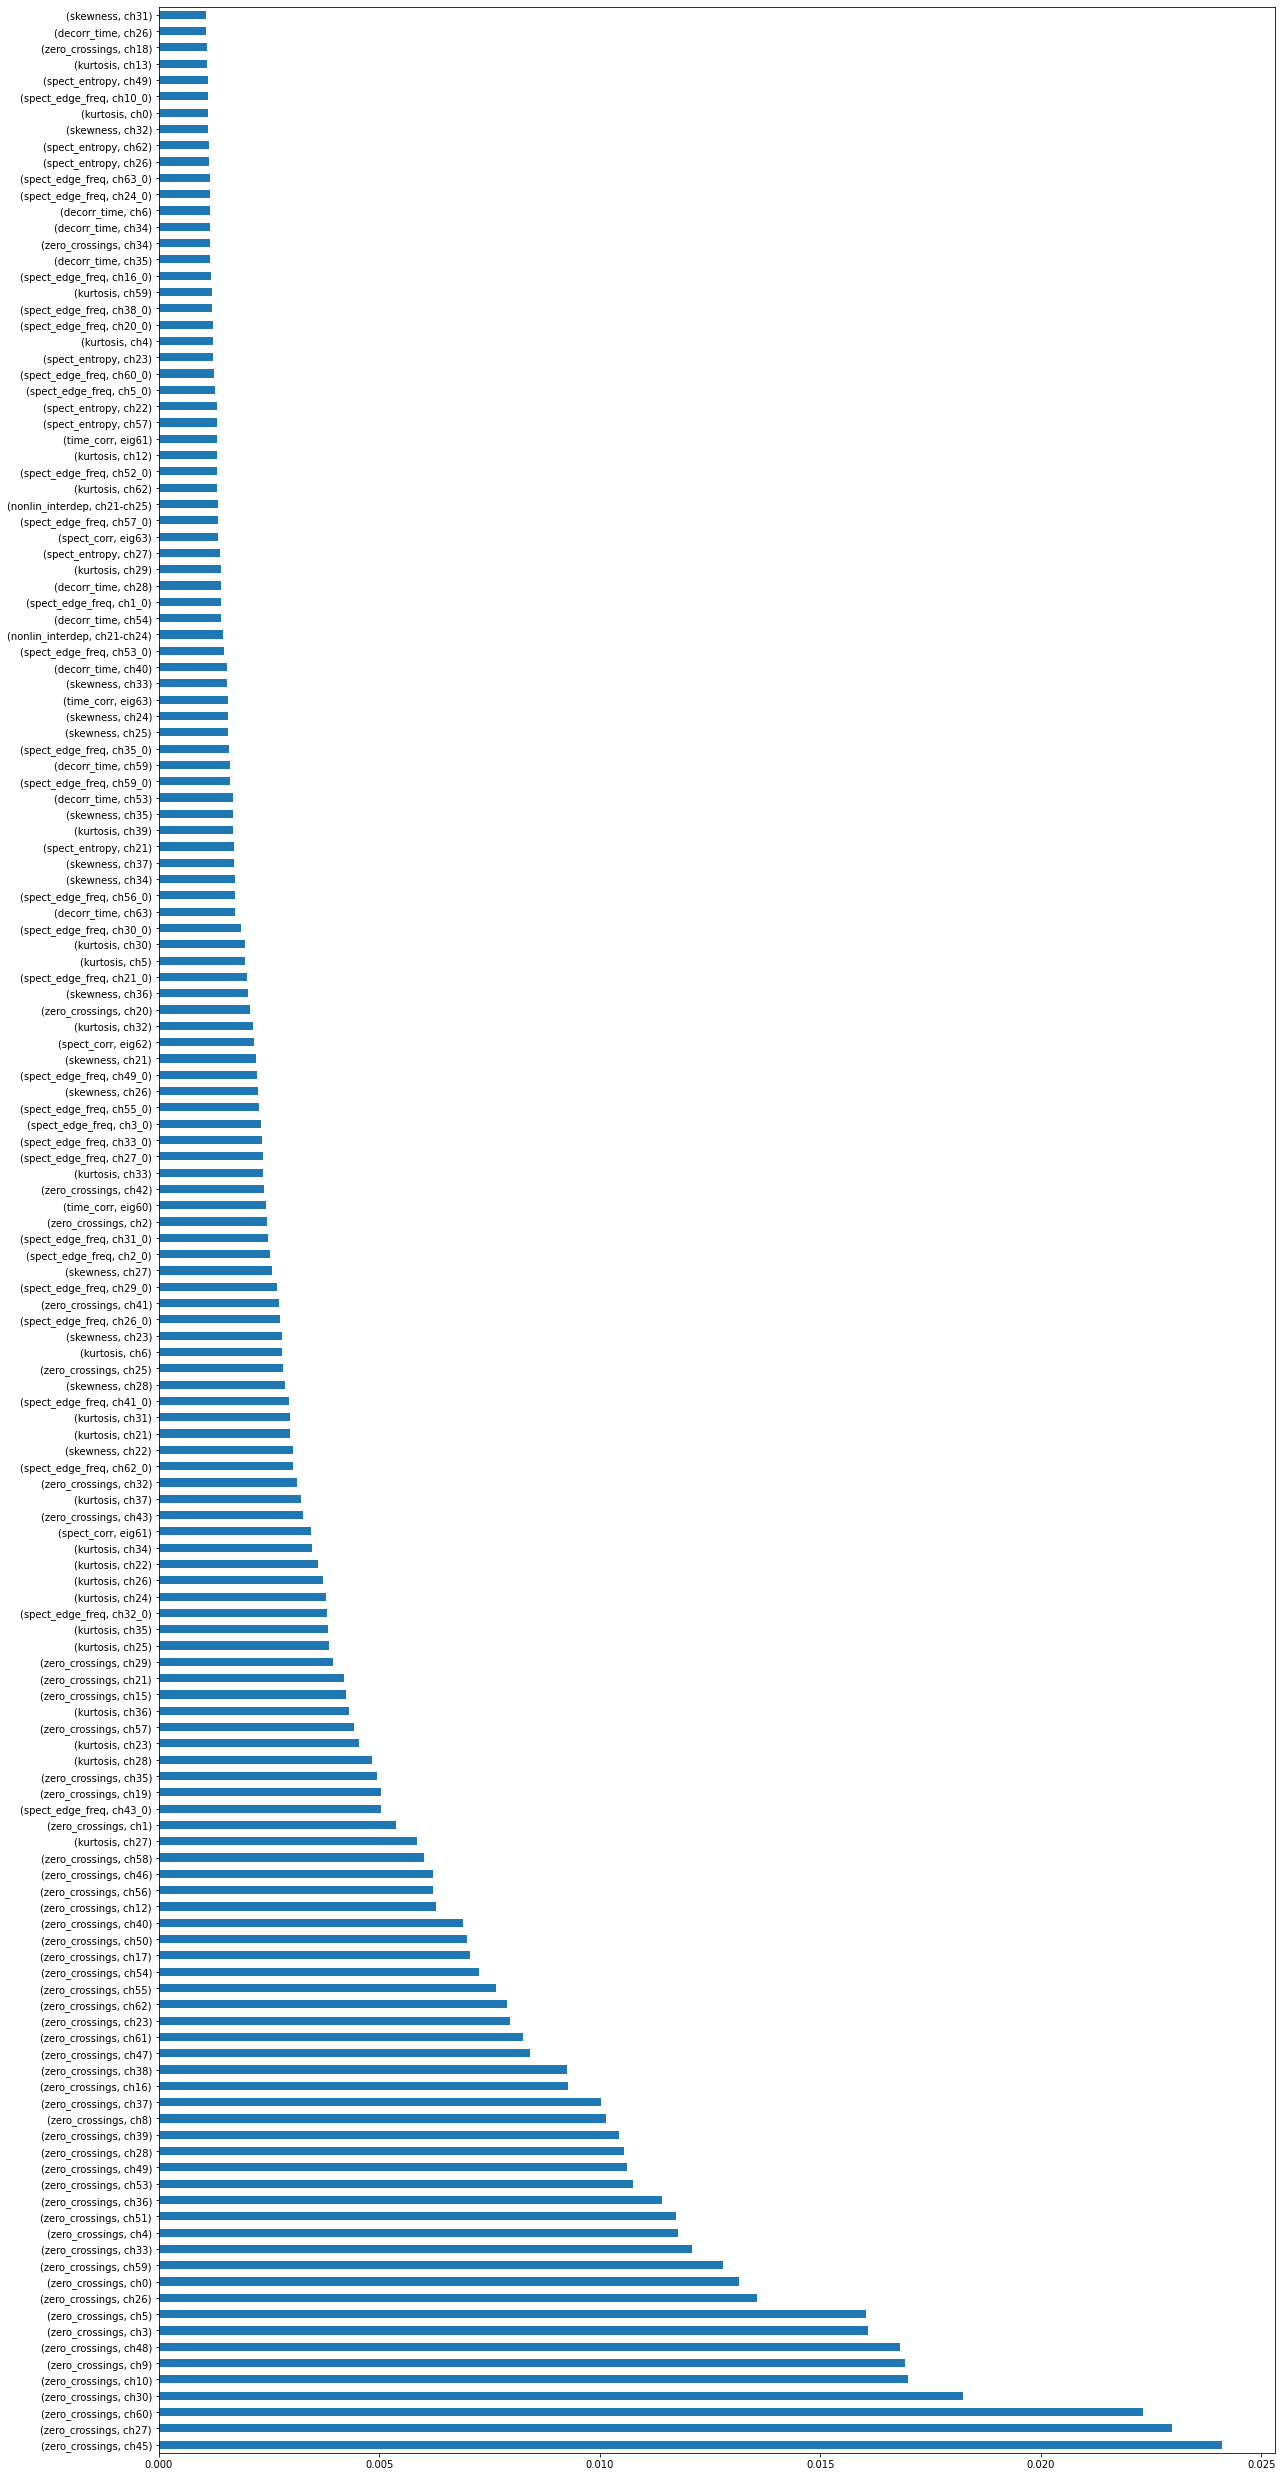

In [18]:
selected_funcs = [
    "std", # selected
    "kurtosis", # selected
    "skewness", # selected
    "samp_entropy",
    "decorr_time",
    "zero_crossings",
    "line_length",
    "spect_slope",
    "spect_entropy",
    "svd_entropy",
    "svd_fisher_info",
    "spect_edge_freq",
    "wavelet_coef_energy",
    "teager_kaiser_energy",
    "max_cross_corr",
    "phase_lock_val",
    "nonlin_interdep",
    "time_corr",
    "spect_corr"
]

X_df = extract_features(epochs.get_data(), selected_funcs=selected_funcs, sfreq=raw_obj.info['sfreq'], return_as_df=True, n_jobs=1)
X = X_df.values

svm_clf = SVC(C=0.5, kernel='linear')
svm_clf.fit(X, y)

svm_clf.coef_.shape
import pandas as pd
pd.Series(abs(svm_clf.coef_[0]), index=X_df.columns.values).nlargest(150).plot(kind='barh', figsize=(20,45))

Selected:

- mean
- variance
- std
- spect_edge_freq
- kurtosis
- zero_crossings
- spect_slope

In [11]:
selected_funcs = [
    "mean",
    "variance",
    "std",
    "spect_edge_freq",
    "kurtosis",
    "zero_crossings",
    "spect_slope",
]

In [12]:
X_df = extract_features(epochs.get_data(), selected_funcs=selected_funcs, sfreq=raw_obj.info['sfreq'], return_as_df=True, n_jobs=1)
X = X_df.values

/Users/owalid/.pyenv/versions/3.8.12/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/owalid/.pyenv/versions/3.8.12/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/owalid/.pyenv/versions/3.8.12/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/owalid/.pyenv/versions/3.8.12/lib/python3.8/site-packages/sklearn/

In [13]:
shuffle_split = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
models = [
    ('Linear discriminant analysis', LinearDiscriminantAnalysis(), {'model__solver': ['svd'], 'model__tol': [0.0001, 0.00001]}),   
    ('SVM', SVC(), {'model__C': [0.5, 1, 3], 'model__kernel': ['linear']}),
    ('KNN', KNeighborsClassifier(), {'model__n_neighbors': [4,5,6]})
]

pipelines = []
for name, model, param_grid in models:
    pipeline = Pipeline([
        ('model', model)
    ])
    pipelines.append((name, pipeline, param_grid))

results = []
for name, pipeline, param_grid in pipelines:
    grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=shuffle_split, n_jobs=1)
    grid_search.fit(X, y)
    results.append((name, grid_search))

res_grid = []
for name, grid_search in results:
    print(f"Model: {name}")
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Best Cross-Validated Accuracy: {grid_search.best_score_:.2f}")
    print("\n")

Model: Linear discriminant analysis
Best Parameters: {'model__solver': 'svd', 'model__tol': 0.0001}
Best Cross-Validated Accuracy: 0.50


Model: SVM
Best Parameters: {'model__C': 0.5, 'model__kernel': 'linear'}
Best Cross-Validated Accuracy: 0.42


Model: KNN
Best Parameters: {'model__n_neighbors': 5}
Best Cross-Validated Accuracy: 0.42




/Users/owalid/.pyenv/versions/3.8.12/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/owalid/.pyenv/versions/3.8.12/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value N